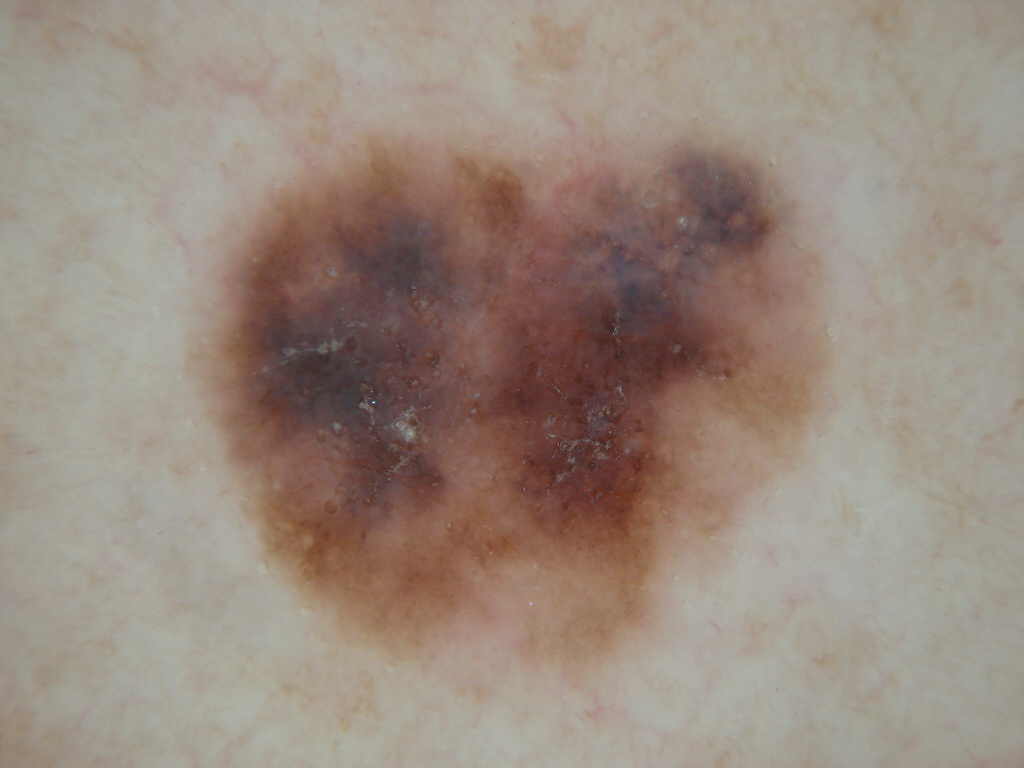

In [8]:
# Check if PIL works
from PIL import Image
Image.open(open("Desktop/skin cancer/train/train/melanoma/ISIC_0010034.jpg", 'rb'))

In [4]:
! pip3 install torch torchvision

You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


## Imports 

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.functional as F
from torch import optim

from torchvision import datasets, transforms, models
from collections import OrderedDict

## Explore data 

The data was pulled from the [2017 ISIC Challenge on Skin Lesion Analysis Towards Melanoma Detection](https://challenge.kitware.com/#challenge/583f126bcad3a51cc66c8d9a). And there are:
- 2000 images for training 
- 150 images for validation
- 600 images for testing 

I used this section to explore the training data and see what kind of images it contains. 

In [10]:
import glob 
import cv2

train_dir = ["Desktop/skin cancer/train/train/melanoma", 
               "Desktop/skin cancer/train/train/nevus",
               "Desktop/skin cancer/train/train/seborrheic_keratosis"]

test_dir = ["Desktop/skin cancer/test/melanoma", 
              "Desktop/skin cancer/test/nevus",
              "Desktop/skin cancer/test/seborrheic_keratosis"]

def get_images_paths(directory, n_per_class):
  img_paths = []
  for i in range(3):
    cont = 1
    for file in glob.glob(directory[i]+"/*.jpg"):
      img_paths.append(file)
      if cont == n_per_class:
        break
      cont +=1 
  return img_paths

# Get a sample of 15 training images (5 for each class)
img_paths = get_images_paths(train_dir, 5)
print(len(img_paths))
print(img_paths)

15
['Desktop/skin cancer/train/train/melanoma\\ISIC_0000002.jpg', 'Desktop/skin cancer/train/train/melanoma\\ISIC_0000004.jpg', 'Desktop/skin cancer/train/train/melanoma\\ISIC_0000013.jpg', 'Desktop/skin cancer/train/train/melanoma\\ISIC_0000022.jpg', 'Desktop/skin cancer/train/train/melanoma\\ISIC_0000026.jpg', 'Desktop/skin cancer/train/train/nevus\\ISIC_0000000.jpg', 'Desktop/skin cancer/train/train/nevus\\ISIC_0000001.jpg', 'Desktop/skin cancer/train/train/nevus\\ISIC_0000003.jpg', 'Desktop/skin cancer/train/train/nevus\\ISIC_0000006.jpg', 'Desktop/skin cancer/train/train/nevus\\ISIC_0000007.jpg', 'Desktop/skin cancer/train/train/seborrheic_keratosis\\ISIC_0012090.jpg', 'Desktop/skin cancer/train/train/seborrheic_keratosis\\ISIC_0012103.jpg', 'Desktop/skin cancer/train/train/seborrheic_keratosis\\ISIC_0012117.jpg', 'Desktop/skin cancer/train/train/seborrheic_keratosis\\ISIC_0012155.jpg', 'Desktop/skin cancer/train/train/seborrheic_keratosis\\ISIC_0012170.jpg']


In [11]:
# Read images 
images = []
for path in img_paths: 
  image = cv2.imread(path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  images.append(image)

# Check if images has the same shape
for i in range(len(images)):
  print("image: ", i, " has shape: ", images[i].shape)

image:  0  has shape:  (767, 1022, 3)
image:  1  has shape:  (767, 1022, 3)
image:  2  has shape:  (767, 1022, 3)
image:  3  has shape:  (1129, 1504, 3)
image:  4  has shape:  (1129, 1504, 3)
image:  5  has shape:  (767, 1022, 3)
image:  6  has shape:  (767, 1022, 3)
image:  7  has shape:  (767, 1022, 3)
image:  8  has shape:  (767, 1022, 3)
image:  9  has shape:  (767, 1022, 3)
image:  10  has shape:  (2848, 4288, 3)
image:  11  has shape:  (2000, 3008, 3)
image:  12  has shape:  (2000, 3008, 3)
image:  13  has shape:  (2000, 3008, 3)
image:  14  has shape:  (2000, 3008, 3)


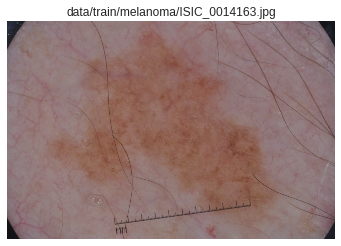

In [32]:
# Visualize images
index = 4

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_title(img_paths[index])
ax1.imshow(images[index])

In [14]:
model = models.inception_v3(pretrained=True)
model

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

## Load data

In [0]:
root_path = "Desktop/skin cancer/"

# With data augmentation
train_transforms = transforms.Compose([transforms.Resize((350,350)),
                                       transforms.CenterCrop(299),
                                       transforms.RandomRotation(0, 359),
                                       transforms.RandomVerticalFlip(0.5),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize((300,300)),
                                       transforms.CenterCrop(299),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

test_transforms = valid_transforms

train_data = datasets.ImageFolder(root_path+'train/train', transform=train_transforms)
valid_data = datasets.ImageFolder(root_path+'valid', transform=valid_transforms)
test_data = datasets.ImageFolder(root_path+'test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=32)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)

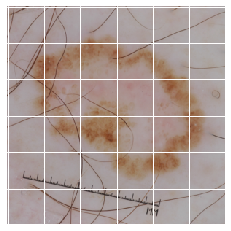

In [19]:
# Visualize different training images
import numpy as np 

def imshow(image, ax=None, title=None, normalize=True):
  """Imshow for Tensor."""
  if ax is None:
    fig, ax = plt.subplots()
  image = image.numpy().transpose((1, 2, 0))
  
  if normalize:
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    
  ax.imshow(image)
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  ax.tick_params(axis='both', length=0)
  ax.set_xticklabels('')
  ax.set_yticklabels('')
  return ax

images, labels = next(iter(trainloader))
imshow(images[7])

## Build model

### Freeze parameters of inception-v3

This is done when you are using transfer learning, and you just want to train the last part of the model, the classifier.  However, in this case, I notice that I obtained better results if I initialized the network with the pretrained weights and trained the whole model instead of just the classifier. 



In [0]:
for parameters in model.parameters():
  parameters.requires_grad = False 

### Create the classifier

In [0]:
BasicConv2d = nn.Sequential(OrderedDict([('conv', nn.Conv2d(2048, 192, kernel_size=(1,1), stride=(1,1))),
                                         ('bn', nn.BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True))]))

classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(2048, 512)),
                                         ('relu', nn.ReLU()),
                                         ('drop', nn.Dropout(0.5)),
                                         ('fc2', nn.Linear(512, 3)), 
                                         ('output', nn.Softmax(dim=1))]))

model.Mixed_7c.branch_pool = BasicConv2d
model.fc = classifier

## Train classifier

### Check for GPU

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Accuracy before training

In [19]:
def accuracy(validloader):    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in validloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device) 
            outputs, aux = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network %d %%' % (100 * correct / total))

model.to(device)
accuracy(validloader)

Accuracy of the network 47 %


### Check how much time will take on a simple batch

In [13]:
import time

criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.fc.parameters(), lr=0.001)

model.to(device)
model.train()

inputs, labels = next(iter(trainloader))
inputs, labels = inputs.to(device), labels.to(device)

start = time.time()

outputs = model.forward(inputs)
# Inception has multiple outputs
loss = sum((criterion(out, labels) for out in outputs))
loss.backward()
optimizer.step()

print(f"Device = GPU; Time per batch: {(time.time() - start):.3f} seconds")

Device = GPU; Time per batch: 1.033 seconds


### Train classifier

In [21]:
def validation(model, validloader, criterion):
    test_loss = 0
    accuracy = 0
    for images, labels in validloader:
      images, labels = images.to(device), labels.to(device)
      outputs = model.forward(images)
      test_loss += criterion(outputs, labels).item()
      ps = torch.exp(outputs)
      equality = (labels.data == ps.max(dim=1)[1])
      accuracy += equality.type(torch.FloatTensor).mean()
    return test_loss, accuracy
  
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.0001, momentum=0, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

model.to(device)

running_loss = 0
step = 0
print_every = 1
epochs = 5


model.train()
for epoch in range(epochs):
  scheduler.step()
  for inputs, labels in trainloader:
    inputs, labels = inputs.to(device), labels.to(device)
    step += 1
    optimizer.zero_grad()
    outputs = model.forward(inputs)
    loss = sum((criterion(out, labels) for out in outputs))
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    if step % print_every == 0:
      model.eval()
      with torch.no_grad():
        test_loss, accuracy = validation(model, validloader, criterion)
        print("Epoch: {}/{}.. ".format(epoch+1,epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/print_every),
              "Validation Loss: {:.3f}.. ".format(test_loss/len(validloader)))
      running_loss = 0
      model.train()
    

Epoch: 1/2..  Training Loss: 9.582..  Validation Loss: 1.062.. 
Epoch: 1/2..  Training Loss: 7.897..  Validation Loss: 1.057.. 
Epoch: 1/2..  Training Loss: 6.555..  Validation Loss: 1.049.. 
Epoch: 1/2..  Training Loss: 5.903..  Validation Loss: 1.050.. 
Epoch: 1/2..  Training Loss: 4.827..  Validation Loss: 1.046.. 
Epoch: 1/2..  Training Loss: 4.351..  Validation Loss: 1.043.. 
Epoch: 1/2..  Training Loss: 3.842..  Validation Loss: 1.036.. 
Epoch: 1/2..  Training Loss: 3.406..  Validation Loss: 1.030.. 
Epoch: 1/2..  Training Loss: 4.012..  Validation Loss: 1.054.. 
Epoch: 1/2..  Training Loss: 4.115..  Validation Loss: 1.048.. 
Epoch: 1/2..  Training Loss: 3.252..  Validation Loss: 1.018.. 
Epoch: 1/2..  Training Loss: 3.515..  Validation Loss: 1.022.. 
Epoch: 1/2..  Training Loss: 3.841..  Validation Loss: 1.023.. 
Epoch: 1/2..  Training Loss: 3.162..  Validation Loss: 1.031.. 
Epoch: 1/2..  Training Loss: 2.830..  Validation Loss: 1.019.. 
Epoch: 1/2..  Training Loss: 2.867..  Va

In [0]:
torch.save(model.state_dict(), "./model.pth")

## Evaluate model

The model is ranked according to three separate categories:
- Category 1 (Score 1): ROC AUC for melanoma classification.
> This is the ability to distiguish  between malignant melanoma and the benign skin lesions (nevus, seborrheic keratosis) by calculating the area under the receiver operating characteristic curve ([ROC AUC](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)) corresponding to this binary classification task.

- Category 2 (Score 2): ROC AUC for melanocytic classification: 
> All of the skin lesions that we will examine are caused by abnormal growth of either melanocytes or keratinocytes, which are two different types of epidermal skin cells. Melanomas and nevi are derived from melanocytes, whereas seborrheic keratoses are derived from keratinocytes. The second caterory tests the ability to distinguish between melanocytic and keratinocytic skin lesions.

- Category 3 (Score 3): Mean ROC AUC:
> This catefory take the average of the ROC AUC values from the first two categories.




### Load the model

In [0]:
state_dict = torch.load('./badmodel.pth')
model.load_state_dict(state_dict)

### Check accuracy

In [0]:
model.to(device)

In [27]:
def check_accuracy_on_test(testloader):    
    correct = 0
    total = 0
    with torch.no_grad():
        cont = 1
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            cont += 1
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return (100*correct/total)

model.eval()
accuracy = check_accuracy_on_test(testloader)
print('Accuracy of the network on the 600 test images: %d %%' % accuracy)

Accuracy of the network on the 600 test images: 73 %


### Get predictions

In [28]:
img_paths = [line.rstrip('\n') for line in open('ordered_paths.txt')] 

print(len(img_paths))

600


In [29]:
print(img_paths[0])

data/test/melanoma/ISIC_0012258.jpg


In [30]:
print("first five: ", img_paths[:5], "\nMiddle five: ", img_paths[300:305], "\nLast five: ", img_paths[-5:])

first five:  ['data/test/melanoma/ISIC_0012258.jpg', 'data/test/melanoma/ISIC_0012356.jpg', 'data/test/melanoma/ISIC_0012369.jpg', 'data/test/melanoma/ISIC_0012395.jpg', 'data/test/melanoma/ISIC_0012425.jpg'] 
Middle five:  ['data/test/nevus/ISIC_0015217.jpg', 'data/test/nevus/ISIC_0015218.jpg', 'data/test/nevus/ISIC_0015223.jpg', 'data/test/nevus/ISIC_0015224.jpg', 'data/test/nevus/ISIC_0015226.jpg'] 
Last five:  ['data/test/seborrheic_keratosis/ISIC_0014647.jpg', 'data/test/seborrheic_keratosis/ISIC_0014648.jpg', 'data/test/seborrheic_keratosis/ISIC_0014649.jpg', 'data/test/seborrheic_keratosis/ISIC_0014652.jpg', 'data/test/seborrheic_keratosis/ISIC_0014653.jpg']


In [31]:
import numpy as np
from PIL import Image

def load_image(path):
  image = Image.open(path)
  image = test_transforms(image)
  image = torch.tensor(image, requires_grad=True)
  image = image.unsqueeze(0)
  return image

def get_predictions(img_paths):
    
  pred_rank1 = [] # Is melanoma?
  pred_rank2 = [] # Is seborrheic?
  for img_path in img_paths:
    img = load_image(img_path)
    #img.to(device)
    prediction = model(img)
    #img.to("cpu")
    pred_rank1.append(float(prediction.data[0][0]))
    pred_rank2.append(float(prediction.data[0][2]))
  return pred_rank1, pred_rank2

model.to("cpu")
model.eval()
print("")

In [0]:
task1, task2 = get_predictions(img_paths)

In [33]:
print("Task 1 predictions: ", len(task1))
print("first five predictions (Task 1): ", task1[:5])

print("Task 2 predictions: ", len(task2))
print("first five predictions (Task 2): ", task2[:5])

Task 1 predictions:  600
first five predictions (Task 1):  [0.11831827461719513, 0.2719895839691162, 0.24858605861663818, 0.006352662108838558, 1.734638681227807e-05]
Task 2 predictions:  600
first five predictions (Task 2):  [0.5294775366783142, 0.4418347477912903, 0.28174299001693726, 0.002553833881393075, 1.4563238437403925e-05]


In [0]:
import csv
        
with open('results.csv', 'w', newline='') as csvfile:
  doc = csv.writer(csvfile)
  doc.writerow(['Id', 'task_1', 'task_2'])
  for i in range(len(img_paths)):
    doc.writerow([img_paths[i], task1[i], task2[i]])

### Get scores

In [2]:
import os
os.sys.path

['',
 'C:\\Users\\thiyagu22\\Anaconda3\\python36.zip',
 'C:\\Users\\thiyagu22\\Anaconda3\\DLLs',
 'C:\\Users\\thiyagu22\\Anaconda3\\lib',
 'C:\\Users\\thiyagu22\\Anaconda3',
 'C:\\Users\\thiyagu22\\Anaconda3\\lib\\site-packages',
 'C:\\Users\\thiyagu22\\Anaconda3\\lib\\site-packages\\twilio-6.20.0-py3.6.egg',
 'C:\\Users\\thiyagu22\\Anaconda3\\lib\\site-packages\\pyjwt-1.6.4-py3.6.egg',
 'C:\\Users\\thiyagu22\\Anaconda3\\lib\\site-packages\\win32',
 'C:\\Users\\thiyagu22\\Anaconda3\\lib\\site-packages\\win32\\lib',
 'C:\\Users\\thiyagu22\\Anaconda3\\lib\\site-packages\\Pythonwin',
 'C:\\Users\\thiyagu22\\Anaconda3\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\thiyagu22\\.ipython']

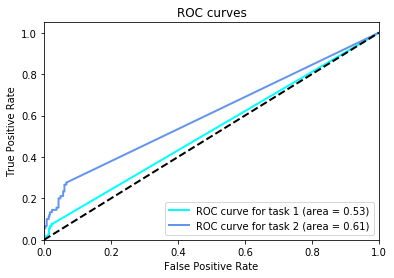

Category 1 Score: 0.526
Category 2 Score: 0.606
Category 3 Score: 0.566


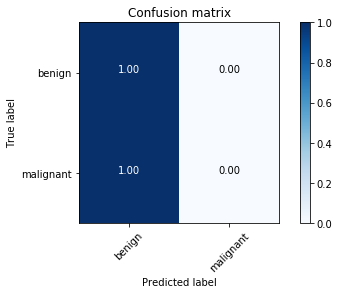

In [4]:
import pandas as pd
import sys
import itertools
import get_results as results

threshold = 0.5 

# get ground truth labels for test dataset
truth = pd.read_csv('ground_truth.csv')
y_true = truth.as_matrix(columns=["task_1", "task_2"])

# get model predictions for test dataset
y_pred = pd.read_csv('sample_predictions.csv')
y_pred = y_pred.as_matrix(columns=["task_1", "task_2"])

# plot ROC curves and print scores
results.plot_roc_auc(y_true, y_pred)
# plot confusion matrix
classes = ['benign', 'malignant']
results.plot_confusion_matrix(y_true[:,0], y_pred[:,0], threshold, classes)